# Exploratory Data Analysis Notebook

In [33]:
'''Import Statements'''

import xarray as xr
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
from datetime import datetime
import pandas as pd

In [2]:
'''Use This Cell to Subset/Extract'''

'''
with zipfile.ZipFile("Copernicus_ENA_Satelite Maps_Training_Data-20250111T200551Z-001.zip", "r") as zip_ref:
    # List all files in the zip
    archive = zip_ref.namelist()

    for file in archive:
        if file.split('_')[6].startswith('2005'):
            zip_ref.extract(file, '2005_hurricane_season')
'''
            
os.listdir("2005_hurricane_season")[0:5]

['dt_ena_20050101_vDT2021.nc',
 'dt_ena_20050102_vDT2021.nc',
 'dt_ena_20050103_vDT2021.nc',
 'dt_ena_20050104_vDT2021.nc',
 'dt_ena_20050105_vDT2021.nc']

In [34]:
'''Get Buoy Locations'''

buoys = {}

for csv in os.listdir("Training_Anomalies_Station Data"):
    data = pd.read_csv("./Training_Anomalies_Station Data/" + csv)
    buoys[data['location'].unique()[0]] = (np.mean(data['latitude']), np.mean(data['longitude']))

buoys

{'Atlantic City': (39.35666700000001, -74.41805300000001),
 'Baltimore': (39.266944, -76.579444),
 'Eastport': (44.904598, -66.98290299999996),
 'Fort Pulaski': (32.036699999999996, -80.90169999999998),
 'Lewes': (38.78278, -75.11916399999998),
 'Newport': (41.50433299999999, -71.326139),
 'New London': (41.36140100000001, -72.08999600000003),
 'Portland': (43.658059999999985, -70.24416999999997),
 'Sandy Hook': (40.466944, -74.00944400000002),
 'Sewells Point': (36.946701, -76.33000200000001),
 'The Battery': (40.700556000000006, -74.01416700000003),
 'Washington': (38.87299999999999, -77.02170000000001)}

In [ ]:
'''Path to Files'''

paths = ["./hurricane_sandy/" + dir 
         for dir in os.listdir("hurricane_sandy")]

xr.open_dataset(paths[0])

<xarray.Dataset>
Dimensions:         (time: 1, latitude: 100, nv: 2, longitude: 160)
Coordinates:
  * time            (time) datetime64[ns] 2012-10-01
  * latitude        (latitude) float32 25.12 25.38 25.62 ... 49.38 49.62 49.88
  * longitude       (longitude) float32 -99.88 -99.62 -99.38 ... -60.38 -60.12
  * nv              (nv) int32 0 1
Data variables: (12/14)
    crs             int32 ...
    lat_bnds        (latitude, nv) float32 ...
    lon_bnds        (longitude, nv) float32 ...
    sla             (time, latitude, longitude) float64 ...
    err_sla         (time, latitude, longitude) float64 ...
    ugosa           (time, latitude, longitude) float64 ...
    ...              ...
    err_vgosa       (time, latitude, longitude) float64 ...
    adt             (time, latitude, longitude) float64 ...
    ugos            (time, latitude, longitude) float64 ...
    vgos            (time, latitude, longitude) float64 ...
    tpa_correction  (time) float64 ...
    flag_ice        (time, latitude, longitude) float64 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2012-10-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2012-09-30T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

In [59]:
'''Plot Each Individual Day of Data'''

index = 0

for nc_file in paths:
    # Open dataset and read in variables.
    dataset = xr.open_dataset(nc_file)
    sla = dataset.variables["sla"][:]
    ua = dataset.variables["ugosa"][:]
    va = dataset.variables["vgosa"][:]
    u = dataset.variables["ugos"][:]
    v = dataset.variables["vgos"][:]
    proj_vel = u * -np.sqrt(2) + v * np.sqrt(2)
    net_on_shore = (-u + v) / 2

    latitude = dataset.variables["latitude"][:]
    longitude = dataset.variables["longitude"][:]
    dataset.close()

    # Get date.
    date = nc_file.split('_')[3]

    # Contour heatmap.
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    lon, lat = np.meshgrid(longitude, latitude)
    cbarticks=np.arange(-2,2.4, 0.4)
    plt.contourf(lon, lat, net_on_shore[0, :, :], cbarticks, cmap="coolwarm")
    cbar = plt.colorbar(label="Current Anomaly (m)")

    # Scatter buoys.
    x = [pair[1] for pair in buoys.values()]
    y = [pair[0] for pair in buoys.values()]
    n = buoys.keys()
    plt.scatter(x, y, color='grey')
    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i], y[i]), xytext=(x[i]-2.5, y[i]+0.25), fontsize=8)

    # Plot labels.
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Current anomaly on {date}")
    plt.savefig(f'./hurricane_sandy_gosa/image{index}')
    plt.close()
    
    index += 1
    

MovieWriter Pillow unavailable; using Pillow instead.


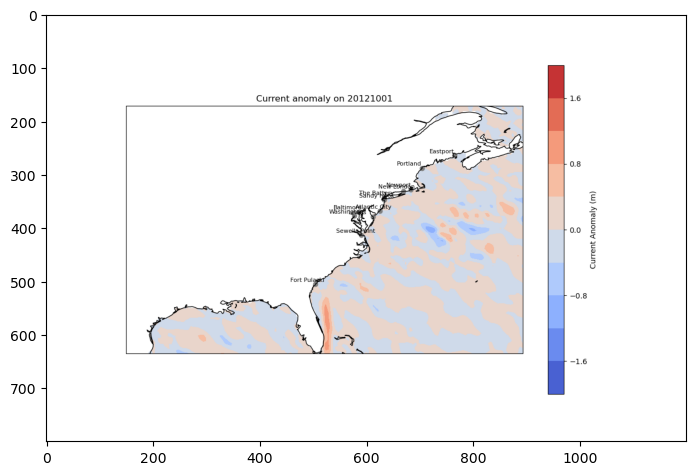

In [60]:
'''Make Animation'''

nframes = 61
plt.subplots_adjust(top=1, bottom=0, left=0, right=1)

def animate(i):
    im = plt.imread('./hurricane_sandy_gosa/image'+str(i)+'.png')
    plt.imshow(im)

anim = FuncAnimation(plt.gcf(), animate, frames=nframes, 
                     interval=(5000.0/nframes))
anim.save('sandy_gosa.gif', writer='Pillow')